# Hard SVM (Support vector machine) using convex Quadratic program 

## Step 1: Import All required Libraries

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_blobs
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import matplotlib.pyplot as plt

## Step 2: Read CSV file (For this i have uploded the file on google colab) 

In [62]:
df = pd.read_csv("file.csv")
print(df.head(),df.shape)

   Temperature  Humidity       Light         CO2  HumidityRatio  Occupancy
0      23.7000    26.272  585.200000  749.200000       0.004764          1
1      23.7180    26.290  578.400000  760.400000       0.004773          1
2      23.7300    26.230  572.666667  769.666667       0.004765          1
3      23.7225    26.125  493.750000  774.750000       0.004744          1
4      23.7540    26.200  488.600000  779.000000       0.004767          1 (2665, 6)


## Step 3: Store the features and target in X , Y seperately and since target has value 0,1 change label 0 to -1 

In [63]:
X = df.iloc[:,:-2].to_numpy()
y = df.iloc[:,-1:].to_numpy()
print(X.shape,X.flatten())
y[y==0]=-1
print(y.shape,y.flatten())


(2665, 4) [  23.7          26.272       585.2        ...   25.68166667  798.
 1124.        ]
(2665, 1) [1 1 1 ... 1 1 1]


## Step 4: Processing the Data and Splitting


In [64]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.83168317, 0.44513204, 0.34479305, 0.33003334],
       [0.8359604 , 0.44705255, 0.34078657, 0.34152347],
       [0.83881188, 0.44065084, 0.33740855, 0.35103018],
       ...,
       [0.98138614, 0.38410243, 0.48136692, 0.71638882],
       [0.98772277, 0.38410243, 0.47901016, 0.71351629],
       [1.        , 0.38214635, 0.47017234, 0.71454219]])

A. Split the data in 70,30 for training and testing the model 

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1865, 4) (800, 4) (1865, 1) (800, 1)


B. Split the data in 80,20 for training and testing the model 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2132, 4) (533, 4) (2132, 1) (533, 1)


C. Split the data in 90,10 for training and testing the model 

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.1, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2398, 4) (267, 4) (2398, 1) (267, 1)


## Step 5: Optimizing the weight vector w using the cvxopt_solvers.
### Create H where Hi,j=y(i)y(j)<x(i)x(j)>
### Calculate w=∑y(i)α(i)x(i)
### Determine the set of support vectors S by finding the indices such that αi>0
### For each new point x′ classify according to y′=sign(wTx′+b)

In [68]:
# Initializing values of m,n and computing gram matrix.
samples,features = X_train.shape
y_train = y_train.reshape(-1,1)
H = np.dot((y_train*X_train),(y_train*X_train).T)

# Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(np.repeat([-1.0], samples)[..., None])
G = cvxopt_matrix(np.negative(np.eye(samples)))
h = cvxopt_matrix(np.zeros(samples))
A = cvxopt_matrix(y_train.reshape(1, -1)*1.0)
b = cvxopt_matrix(0.0)
cvxopt_solvers.options['show_progress']=False

## Step 6: Running the solver and printing the values of solution 

In [69]:
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])
print(sol,alphas.flatten()) 

{'x': <2398x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <2398x1 matrix, tc='d'>, 'z': <2398x1 matrix, tc='d'>, 'status': 'unknown', 'gap': 260971874.9584264, 'relative gap': 0.00023825117631605714, 'primal objective': -1095364476237.5847, 'dual objective': -1095625448111.9617, 'primal infeasibility': 71.1386676051738, 'dual infeasibility': 1.0002827724635441, 'primal slack': 13373.10587901375, 'dual slack': 5.93557280433168e-07, 'iterations': 18} [1.31931387e+06 5.43512248e+08 1.19376018e+08 ... 2.12531653e+08
 5.75481447e+07 2.28620974e+08]


## Calculating W and b Displaying results

In [70]:
# w parameter using alphas 
w = np.dot((y_train * alphas).T,X_train)[0]

# Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b of non zero paprameters
b = y_train[S] - np.dot(X_train[S], w.reshape(-1,1))
b = sum(b)/len(b)

# Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

Alphas =  [1.31931387e+06 5.43512248e+08 1.19376018e+08 ... 2.12531653e+08
 5.75481447e+07 2.28620974e+08]
w =  [-2.78472900e-04 -1.83105469e-04 -3.81469727e-05  8.39233398e-05]
b =  [-0.26926671]


## Printing all support vectors

In [71]:
X_Support_vectors = X_train[S]
y_support_vectors = y_train[S]
print(alphas,'\n',"Support vectors are : = ",X_Support_vectors,'\n','\n',"Number of Support vectors are: ",len(X_Support_vectors))

[[1.31931387e+06]
 [5.43512248e+08]
 [1.19376018e+08]
 ...
 [2.12531653e+08]
 [5.75481447e+07]
 [2.28620974e+08]] 
 Support vectors are : =  [[0.0950495  0.24433182 0.         0.04180559]
 [0.63920792 0.58682315 0.25497128 0.6320595 ]
 [0.04514851 0.04267805 0.         0.00769428]
 ...
 [0.14019802 0.28700987 0.25511857 0.25151748]
 [0.48237624 0.28736552 0.         0.34444729]
 [0.07128713 0.22192585 0.24286346 0.11644011]] 
 
 Number of Support vectors are:  2398


## Step 7: Creating target Array and calculating the target values.

In [72]:
target = np.where(np.dot(X_test,w)+b>=0.0,1,-1)
t = np.where(np.dot(X_train,w)+b>=0.0,1,-1)

## Step 8: Checking for Accuracy. 

In [73]:
v1 = 0  
v2 = 0
c = 0
i=0    
for c in range( np.size( target ) ) :  
  if y_test[c] == target[c] :            
    v1 = v1 + 1
  c = c + 1
for i in range( np.size( t ) ) :
  if y_train[i] == t[i] :            
    v2 = v2 + 1
  i = i + 1
print("Accuracy of Defined Model on test data :",(v1/c)*100)     
print("Accuracy of Defined Model on train data:",(v2/i)*100)   

Accuracy of Defined Model on test data : 64.04494382022472
Accuracy of Defined Model on train data: 63.46955796497081


## For Any randomly generated Linear separable data

(700, 2) (300, 2) (700,) (300,)


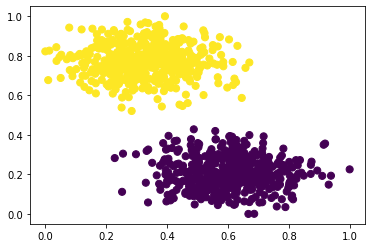

In [85]:
# geberating linearly separable data.
x, y = make_blobs(n_samples = 1000, centers = 2, random_state = 0, cluster_std = 0.50)
y[y==0]=-1
# changeing some points to irregular or impurities
for i in range(len(y)):
  if y[i] == -1 :
    y[i]=1
  else:
    y[i]=-1
  i=i**2
# pre processing the data
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scale = min_max_scaler.fit_transform(x)
x_scale
X_train, X_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# plotting the data
plt.scatter(x_scale[:, 0], x_scale[:, 1], c = y, s = 50)

In [86]:
# Initializing values of m,n and computing gram matrix.
samples,features = X_train.shape
y_train = y_train.reshape(-1,1)
H = np.dot((y_train*X_train),(y_train*X_train).T)

# Converting into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(np.repeat([-1.0], samples)[..., None])
G = cvxopt_matrix(np.negative(np.eye(samples)))
h = cvxopt_matrix(np.zeros(samples))
A = cvxopt_matrix(y_train.reshape(1, -1)*1.0)
b = cvxopt_matrix(0.0)
cvxopt_solvers.options['show_progress']=True

In [87]:
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])
print(sol,alphas.flatten()) 

     pcost       dcost       gap    pres   dres
 0: -5.2785e+01 -1.1052e+02  2e+03  4e+01  2e+00
 1: -4.8873e+01 -7.4035e+01  7e+02  1e+01  7e-01
 2: -8.1421e+01 -1.0235e+02  6e+02  1e+01  5e-01
 3: -2.4338e+02 -1.8213e+02  5e+02  6e+00  3e-01
 4: -1.2688e+02 -1.2851e+02  7e+01  7e-01  3e-02
 5: -1.1642e+02 -1.1689e+02  1e+00  1e-02  4e-04
 6: -1.1663e+02 -1.1666e+02  1e-01  7e-04  3e-05
 7: -1.1666e+02 -1.1666e+02  3e-03  1e-05  5e-07
 8: -1.1666e+02 -1.1666e+02  3e-05  1e-07  5e-09
 9: -1.1666e+02 -1.1666e+02  3e-07  1e-09  5e-11
Optimal solution found.
{'x': <700x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <700x1 matrix, tc='d'>, 'z': <700x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 2.622020560297984e-07, 'relative gap': 2.247617083864587e-09, 'primal objective': -116.65779634445748, 'dual objective': -116.65779649042895, 'primal infeasibility': 1.2197578211673499e-09, 'dual infeasibility': 5.3966335828080824e-11, 'primal slack': 5.3310323501099204e-11, 'dual slack': 2.569

In [88]:
# w parameter using alphas 
w = np.dot((y_train * alphas).T,X_train)[0]

# Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

#Computing b of non zero paprameters
b = y_train[S] - np.dot(X_train[S], w.reshape(-1,1))
b = sum(b)/len(b)

# Display results
print('Alphas = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)
X_Support_vectors = X_train[S]
y_support_vectors = y_train[S]
print(alphas.flatten(),'\n',"Support vectors are : = ",X_Support_vectors.flatten(),'\n','\n',"Number of Support vectors are: ",len(X_Support_vectors))

Alphas =  [ 79.50072855 116.65779639  37.15704576]
w =  [-2.49737947 15.06913032]
b =  [-6.23093325]
[3.16080842e-11 4.85492476e-11 2.29400972e-11 3.77300439e-11
 1.68054952e-11 4.34505767e-11 6.09955223e-11 4.95582164e-11
 6.40326862e-11 1.99644857e-11 6.33721137e-11 2.81603610e-11
 3.05961409e-11 4.30645417e-11 2.33277709e-11 6.88106535e-11
 6.91173724e-11 2.54373980e-11 6.18286098e-11 1.08376799e-10
 4.68313529e-11 2.12636925e-11 2.41159880e-11 5.53770357e-11
 4.64977758e-11 6.44753687e-11 1.14591460e-10 4.71672574e-11
 3.17646180e-11 7.37625684e-11 4.14628667e-11 8.76017910e-12
 1.97732215e-11 4.40040460e-11 5.74616290e-11 4.34538499e-11
 3.97649393e-11 2.61502765e-11 4.95609752e-11 7.50870030e-11
 4.79556652e-11 8.68858636e-11 4.57823339e-11 9.64498553e-11
 2.34343589e-11 6.80759844e-11 3.60842865e-11 4.23400896e-11
 1.25220865e-10 2.98796204e-11 3.96672945e-11 1.27061233e-11
 4.97967367e-11 9.80558447e-11 4.82445325e-11 7.20779036e-12
 4.98935192e-11 3.86149529e-11 2.70809924e-11

In [89]:
target = np.where(np.dot(X_test,w)+b>=0.0,1,-1)
t = np.where(np.dot(X_train,w)+b>=0.0,1,-1)
v1 = 0  
v2 = 0
c = 0
i=0    
for c in range( np.size( target ) ) :  
  if y_test[c] == target[c] :            
    v1 = v1 + 1
  c = c + 1 
for i in range( np.size( t ) ) :
  if y_train[i] == t[i] :            
    v2 = v2 + 1
  i = i + 1
print("Accuracy of Defined Model on test data :",(v1/c)*100)     
print("Accuracy of Defined Model on train data:",(v2/i)*100)   

Accuracy of Defined Model on test data : 100.0
Accuracy of Defined Model on train data: 100.0


# Hence we ca see that the hard SVM on Linearly separable data gives 100% accuracy and on non linearly separable data it gives less effeciency.